In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('df.sample.parquet.gzip')
df.shape, df.dtypes

((1000000, 8),
 event_time       datetime64[ns, UTC]
 event_type                  category
 product_id                     int64
 category_id                   uint64
 category_code                 object
 brand                         object
 price                        float32
 user_id                        int64
 dtype: object)

In [3]:
df = df.drop('category_id', axis=1)

In [4]:
df.head()

,event_time,event_type,product_id,category_code,brand,price,user_id
6733995,2019-10-06 08:34:28+00:00,view,16700605,furniture.kitchen.chair,zeta,16.190001,518195082
4880941,2019-10-10 08:31:52+00:00,view,4800725,electronics.audio.headphone,sony,8.210000,512421337
6895456,2019-10-26 08:07:34+00:00,view,8800489,electronics.telephone,hiper,12.100000,518901124
807139,2019-10-07 06:33:45+00:00,cart,4201420,appliances.environment.air_conditioner,lg,787.630005,520085572
6297826,2019-10-25 18:07:49+00:00,view,1004739,electronics.smartphone,xiaomi,189.970001,513345774


In [12]:
# 값이 0인것 그냥 넣기로함
df[df['price']==0].event_type.value_counts()

view        793
cart          2
purchase      0
Name: event_type, dtype: int64

In [18]:
# price의 이상치는 딱히 없음
df['price'].max(), df['price'].min(), df['price'].mean()

(2574.070068359375, 0.0, 352.465)

array([[<AxesSubplot: title={'center': 'event_time'}>,
        <AxesSubplot: title={'center': 'product_id'}>],
       [<AxesSubplot: title={'center': 'price'}>,
        <AxesSubplot: title={'center': 'user_id'}>]], dtype=object)

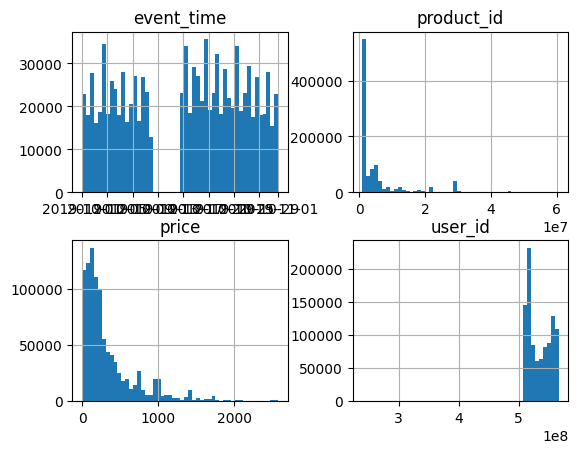

In [19]:
df.hist(bins=50)

In [31]:
# event_type이 purchase인것만 df2

df2 = df[df['event_type'] == 'purchase']
df2.head()

,event_time,event_type,product_id,category_code,brand,price,user_id
3426987,2019-10-23 16:38:27+00:00,purchase,1005204,electronics.smartphone,xiaomi,156.470001,512564650
3995206,2019-10-09 14:25:09+00:00,purchase,1005118,electronics.smartphone,apple,1015.200012,512736880
4641753,2019-10-10 04:55:02+00:00,purchase,1003316,electronics.smartphone,apple,931.789978,526929354
1203259,2019-10-17 08:44:34+00:00,purchase,1004903,electronics.smartphone,huawei,111.699997,552848662
2321640,2019-10-22 21:51:18+00:00,purchase,1002544,electronics.smartphone,apple,458.700012,516355074


In [30]:
# 최근 날짜 기준일 

last_timestamp =  df2['event_time'].max() + dt.timedelta(days=1)
last_timestamp

Timestamp('2019-11-01 23:49:19+0000', tz='UTC')

In [36]:
# RFM 정의
# R : event_time 가장 최신 고객값으로 나누기
# F : event_type에서 purchase 값 count, groupby = userid 
# M: price에서 purchase 값 sum, groupby = userid

rfm = df2.groupby('user_id').agg({'event_time': lambda x : (last_timestamp - x.max()). days,
                                   'product_id': 'count',
                                   'price': 'sum'})
rfm.shape

(18684, 3)

In [37]:
# RFM 으로 변수의 이름을 변경합니다.
# event_time 는 Recency
# product_id 는 Frequency
# price 는 MonetaryValue
rfm.columns = ['Recency', 'Frequency', 'MonetaryValue']
rfm

,Recency,Frequency,MonetaryValue
user_id,,,
435648894,26,1,388.130005
437371552,30,1,179.139999
450756413,29,1,43.730000
456810531,7,1,133.350006
473668240,23,1,149.039993
...,...,...,...
566188229,1,1,221.339996
566210490,1,1,514.780029
566227458,1,1,465.910004


array([[<AxesSubplot: title={'center': 'Recency'}>,
        <AxesSubplot: title={'center': 'Frequency'}>],
       [<AxesSubplot: title={'center': 'MonetaryValue'}>,
        <AxesSubplot: >]], dtype=object)

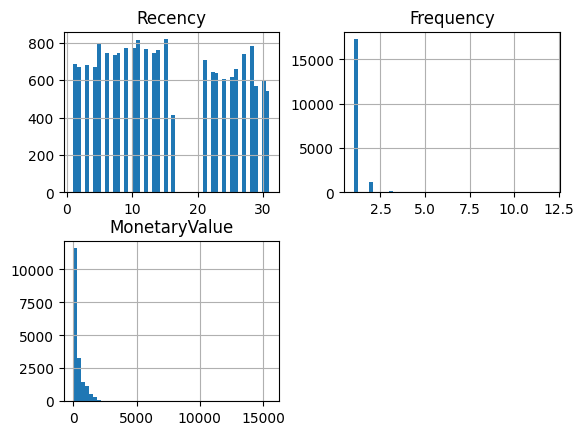

In [38]:
rfm.hist(bins=50)

In [39]:
# F, M 는 값이 높을수록 좋은점수
# R는 값이 낮을수록 최근구매고객이기때문에 높은점수를 줄 예정
r_labels = list(range(5, 0 ,-1))
f_labels = list(range(1, 6))
m_labels = list(range(1, 6))
cut_size = 5

In [40]:
pd.qcut(range(10), 3, labels=['good', 'medium', 'bad'])

['good', 'good', 'good', 'good', 'medium', 'medium', 'medium', 'bad', 'bad', 'bad']
Categories (3, object): ['good' < 'medium' < 'bad']

In [43]:
r_cut = pd.qcut(rfm['Recency'].rank(method='first'), cut_size, labels=list(range(5,0,-1)))
f_cut = pd.qcut(rfm['Frequency'].rank(method='first'), cut_size, labels=list(range(1,6)))
m_cut = pd.qcut(rfm['MonetaryValue'].rank(method='first'), cut_size, labels=list(range(1,6)))

In [44]:
# assign 을 사용하면 여러 변수를 한 번에 만들 수 있습니다.
rfm = rfm.assign(R=r_cut, F=f_cut, M=m_cut)
rfm

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
435648894,26,1,388.130005,2,1,4
437371552,30,1,179.139999,1,1,2
450756413,29,1,43.730000,1,1,1
456810531,7,1,133.350006,4,1,2
473668240,23,1,149.039993,2,1,2
...,...,...,...,...,...,...
566188229,1,1,221.339996,5,5,3
566210490,1,1,514.780029,5,5,4
566227458,1,1,465.910004,5,5,4


In [45]:
rfm["RFM_segment"] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm["RFM_segment"]

user_id
435648894    214
437371552    112
450756413    111
456810531    412
473668240    212
            ... 
566188229    553
566210490    554
566227458    554
566246516    555
566258164    555
Name: RFM_segment, Length: 18684, dtype: object

In [46]:
rfm["RFM_score"] = rfm[['R', 'F', 'M']].sum(axis=1)
rfm.head(2)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
user_id,,,,,,,,
435648894,26,1,388.130005,2,1,4,214,7
437371552,30,1,179.139999,1,1,2,112,4


<AxesSubplot: xlabel='RFM_segment', ylabel='RFM_score'>

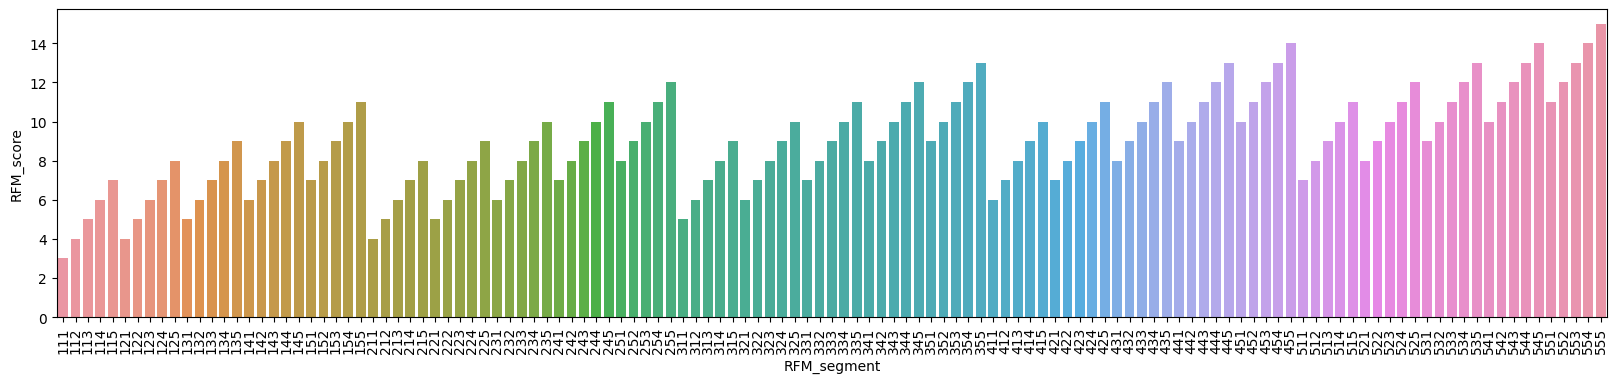

In [49]:
# RFM segment 값에 따라 정렬합니다.
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values('RFM_segment'), x='RFM_segment', y="RFM_score")


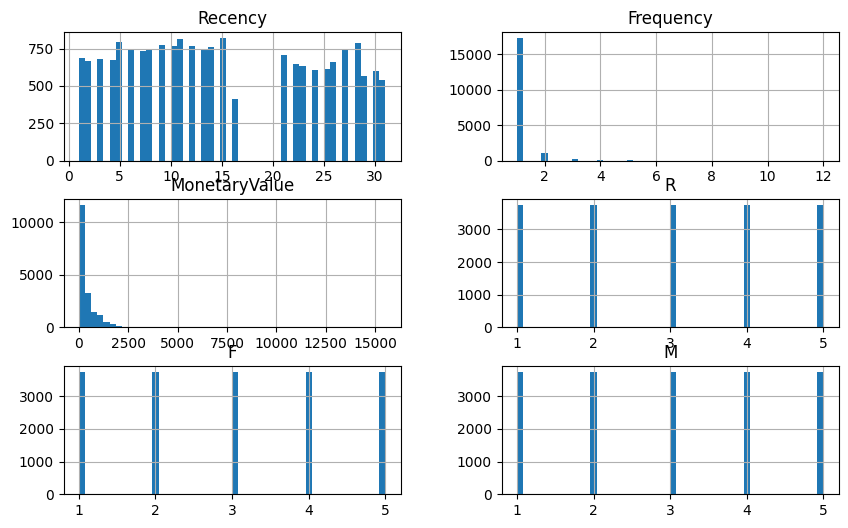

In [50]:
# RFM을 구간화하면 기존에 몰려있던 데이터가 같은 비율로 나뉜것을 볼 수 있다.
rfm.iloc[:, :-2].astype(float).hist(figsize=(10,6), bins=50);

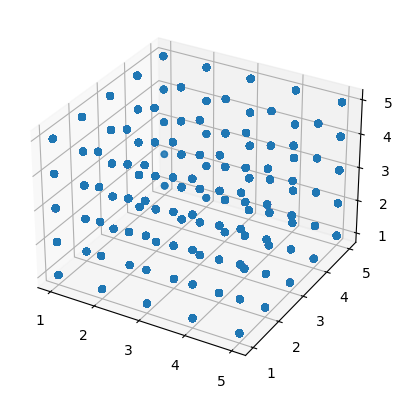

In [51]:
# 3d projection ax.scatter3D rfm["R"], rfm["F"], rfm["M"]
ax = plt.axes(projection='3d')
ax.scatter3D(rfm['R'], rfm['F'], rfm['M'])


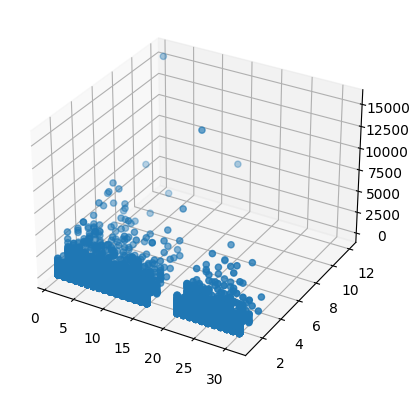

In [52]:
# rfm["Recency"], rfm["Frequency"], rfm["MonetaryValue"]
ax = plt.axes(projection='3d')
ax.scatter(rfm["Recency"], rfm["Frequency"], rfm["MonetaryValue"])

In [53]:
# 문자열의 format 함수를 사용하여 소수점 아래는 표기하지 않도록({:,.0f}) 문자열 포맷을 지정합니다.
a = rfm.groupby('RFM_score').agg({'Recency': 'mean',
                            'Frequency': 'mean',
                            'MonetaryValue': ['mean', 'sum']})

a.style.background_gradient(axis=0).format('{:,.0f}')

In [55]:
# qcut 을 통해 3단계로 "silver", "gold", "platinum" 고객군을 나눕니다. 
labels=['silver', 'gold', 'platinum']
rfm["RFM_class"] = pd.qcut(rfm["RFM_score"], 3, labels)
rfm.sample(3)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
user_id,,,,,,,,,
516609266,4,1,776.940002,5,2,5,525,12,platinum
558481774,12,1,178.410004,3,4,2,342,9,gold
512719476,16,1,1421.319946,3,1,5,315,9,gold


In [56]:
# "RFM_class" 별로 그룹화 하고 "RFM_score" 의 describe 값을 구합니다.
# RFM_score에 따라 RFM_class의 값이 잘 나뉘었는지 확인
rfm.groupby("RFM_class")['RFM_score'].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,8366.0,6.608535,1.308346,3.0,6.0,7.0,8.0,8.0
gold,4870.0,9.486448,0.499868,9.0,9.0,9.0,10.0,10.0
platinum,5448.0,12.237518,1.248803,11.0,11.0,12.0,13.0,15.0


<AxesSubplot: xlabel='RFM_class', ylabel='RFM_score'>

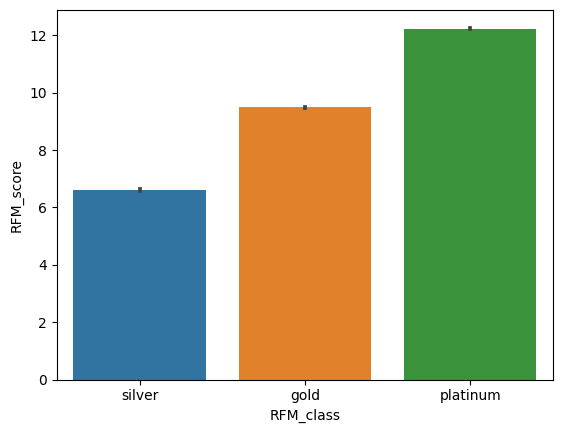

In [57]:
# barplot으로 RFM_class 별 평균 RFM_score 나타냅니다.
sns.barplot(data=rfm, x="RFM_class", y="RFM_score")

<AxesSubplot: xlabel='RFM_class', ylabel='RFM_score'>

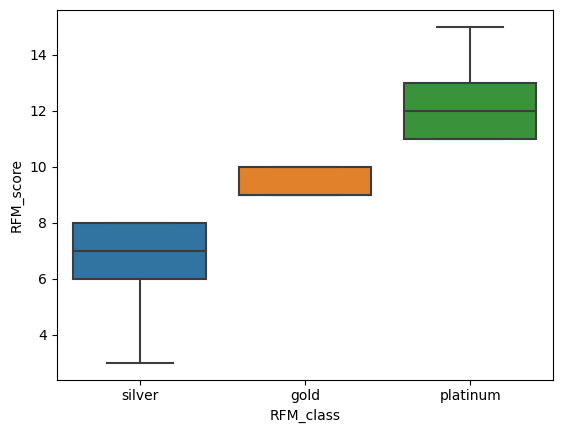

In [58]:
# boxplot으로 RFM_class 별 평균 RFM_score 나타냅니다.
sns.boxplot(data=rfm, x="RFM_class", y="RFM_score")

<AxesSubplot: xlabel='R', ylabel='RFM_score'>

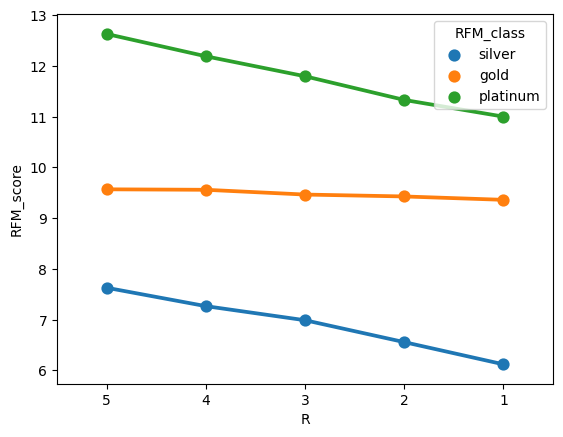

In [59]:
# pointplot으로 x=R, hue=RFM_class 별 평균 y=RFM_score 나타냅니다.
# hue 옵션을 사용하면 특정 컬럼을 지정해서 표기할 수 있습니다.
# 시각화해서 데이터가 의돻ㄴ대로 잘 나뉘었는지 확인해보는 용도
sns.pointplot(data=rfm, x='R', y='RFM_score', hue='RFM_class')

<AxesSubplot: xlabel='F', ylabel='RFM_score'>

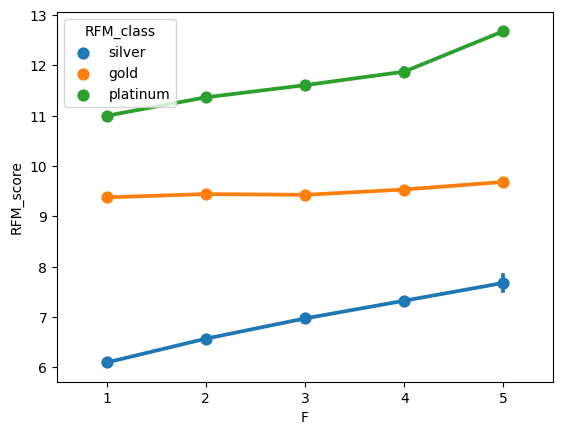

In [60]:
# pointplot으로 x=F, hue=RFM_class 별 평균 y=RFM_score 나타냅니다.
sns.pointplot(data=rfm, x='F', y='RFM_score', hue='RFM_class')

<AxesSubplot: xlabel='M', ylabel='RFM_score'>

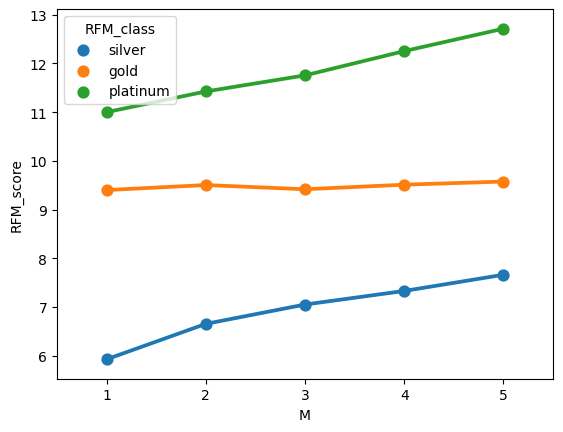

In [61]:
# pointplot으로 x=M, hue=RFM_class 별 평균 y=RFM_score 나타냅니다.
sns.pointplot(data=rfm, x='M', y='RFM_score', hue='RFM_class')

In [62]:
# "RFM_class" 별로 그룹화합니다.
# "Recency", "Frequency" 의 평균을 구합니다.
# "MonetaryValue"의 "mean", "sum", "count" 값을 구합니다.
b =rfm.groupby('RFM_class').agg({'Recency': 'mean', 'Frequency': 'mean',
                              'MonetaryValue': ['mean', 'sum', 'count']})
b

Recency Frequency MonetaryValue                   
                mean      mean          mean          sum count
RFM_class                                                      
silver     20.515300  1.003586    218.376770  1826940.000  8366
gold       13.768994  1.025462    414.418610  2018218.625  4870
platinum    7.986784  1.319016    697.116882  3797892.750  5448

In [63]:
# 위에서 구한 값을 .style.background_gradient() 통해서 시각화합니다.
b.style.background_gradient()

In [64]:
#.style.format("{:,}") 로 천단위에 콤마(,)표기 하도록 문자열 포맷을 지정합니다.
b.style.background_gradient().format('{:,.0f}')

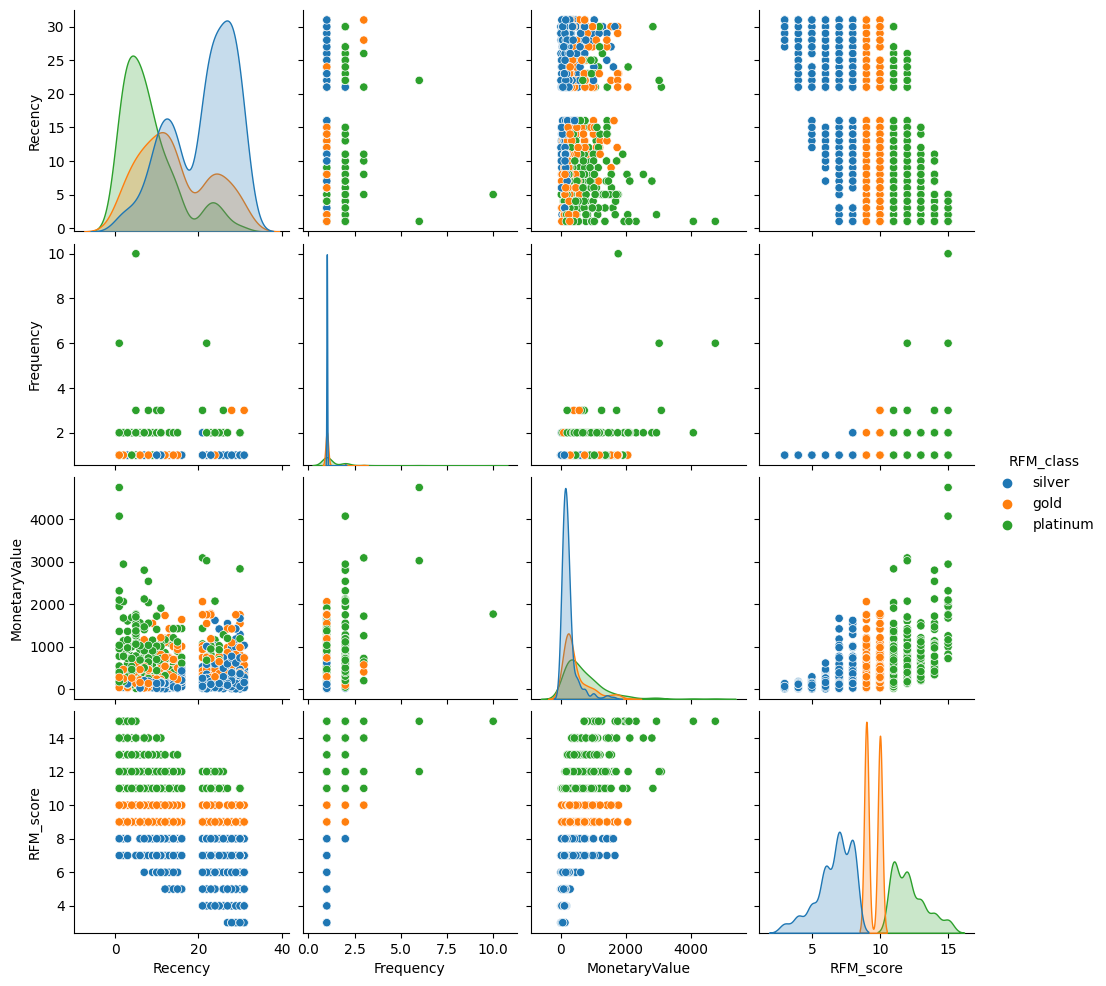

In [65]:
# pairplot 을 통해 "RFM_class" 별로 분포를 시각화 합니다.
# 시간이오래걸려서 sample
sns.pairplot(data=rfm.sample(1000), hue='RFM_class')

In [66]:
# .corr() 함수로 변수간 상관관계(선형적 관계)를 분석합니다.
# 1에 가까울 수록 양의 상관관계, -1에 가까울 수록 음의 상관관계를 나타냅니다.
c = rfm.corr()
c.style.background_gradient()

C:\Users\신하진\AppData\Local\Temp\ipykernel_18916\512574395.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c = rfm.corr()


,Recency,Frequency,MonetaryValue,RFM_score
Recency,1.000000,-0.095449,-0.054167,-0.619715
Frequency,-0.095449,1.000000,0.463629,0.351785
MonetaryValue,-0.054167,0.463629,1.000000,0.478380
RFM_score,-0.619715,0.351785,0.478380,1.000000


<AxesSubplot: >

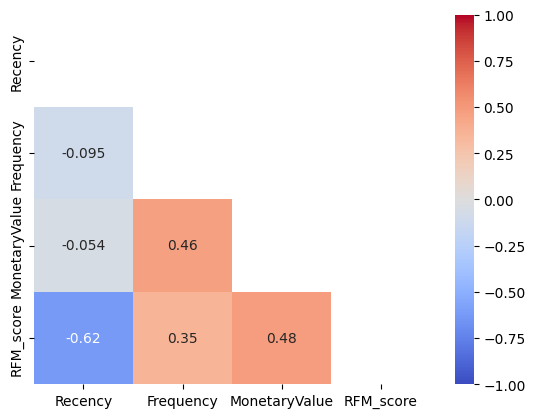

In [67]:
# 삼각형태의 heatmap 형태를 만들기 위해 삼각형 마스크를 만듭니다.
mask = np.triu(np.ones_like(c))
# 상관관계를 열분포 형태의 이미지로 보여주는 heatmap 으로 데이터 시각화합니다.
sns.heatmap(data=c, cmap='coolwarm', vmin=-1, vmax=1, annot=True, mask=mask)